# Throughput, on one CCD, Conway, I/O-Die in p-state P0

## Load necessary depencencies

In [1]:
import numpy
import csv
import re
import os
import matplotlib.pyplot as plt
import matplotlib

## Define functions

In [2]:
# taken from https://github.com/kloopuk/log-progress

# MIT License
#
# Copyright (c) 2016 bureaucratic-labs
# 
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [3]:
# generate lists of files with files according to search parameters
def listgenerator (filelist, startstring, searchpara, retlist):

    searchpara = searchpara + "\""
    
    for file in filelist:
        for line in open(file):
            if line.startswith(startstring):
                if searchpara in line:
                    retlist.append(file)

In [4]:
def evaluation(filelist, size, ins, freq, cores, instruction, unitswitch): 
    
    csvvalues = numpy.array([])
    datapoints = numpy.array([])
    evaluation_vals = numpy.array([])

    coreline = "BENCHIT_KERNEL_CPU_LIST=\"" + cores + "\""
    
    instructionline = "BENCHIT_KERNEL_INSTRUCTION=\"" + instruction + "\"" 

    core_found = False
    instruction_found = False
    data_found = False

    # iterate over lines in file
    for file in filelist:

        # empty arrays
        csvvalues = numpy.array([])
        datapoints = numpy.array([])

        core_found = False
        data_found = False
        instruction_found = False

        for line in open(file):
            if line.startswith('comment='):
                if not line.startswith('comment=\"Frequency ' + freq + '\"'):
                    break
                
            if line.startswith(instructionline):
                instruction_found = True
            # check if file has data for core
            if line.startswith(coreline):
                core_found = True

            # data begins after "beginofdata" string, only search for this when coreline has been found in file
            if line.startswith("beginofdata") and core_found == True and instruction_found == True:
                data_found = True

            # append data to values array, make sure that no strings are appended
            if data_found == True and not line.startswith("endofdata") and not line.startswith("beginofdata"):
                
                # append measurement result
                csvvalues = numpy.append(csvvalues, float(line.split()[int(1)]))

                # append data sizes
                datapoints = numpy.append(datapoints, str(line.split()[0]))

        # process data only when wanted data has been found in file
        if data_found == True:

            # find data size string in datapoints array
            index = numpy.where(datapoints == size)
            
            # save value for given data size and next 4 values to array
            if unitswitch:
                for i in range(4):
                    evaluation_vals = numpy.append(evaluation_vals, 
                                                   ( (csvvalues[index[0] + i] / (float(freq) / 1000) ) )) 
            else:
                for i in range(4):
                    evaluation_vals = numpy.append(evaluation_vals, csvvalues[index[0] + i])

    # calculate average & error
    average = numpy.average(evaluation_vals)
    stdev = numpy.std(evaluation_vals)
    
    return(average, stdev)

In [5]:
# plotter function
def plotter(averages, size_index, frequencies, instructions, cores, unit, file_unit, machine):

    fig, ax = plt.subplots()
    im = ax.imshow(averages, cmap='jet')
    
    levels = ['L1', 'L2', 'L3', 'RAM']
    
    # set title
    ax.set_title(levels[size_index] + ' Throughput in [' + unit + '], on ' + machine + '\n')

    xlabels = numpy.array(cores*len(frequencies))
    ylabels = numpy.array(instructions)
   
    # as many x-ticks as memory locations
    x = numpy.arange(len(xlabels))
    y = numpy.arange(len(ylabels))
    
    ax.set_xlabel('Cores', fontsize='large')
    ax.set_ylabel('Instruction', fontsize='large')

    # use instructions as xticks
    ax.set_xticks(x)
    ax.set_yticks(y)
    ax.set_xticklabels(xlabels, rotation=45, ha='right', rotation_mode='anchor', size='small') 
    ax.set_yticklabels(ylabels, rotation=45, ha='right', rotation_mode='anchor', size='small')
    
    # create colorbar
    cbarlabel = 'Bandwidth in [' + unit +']'
    
    # define cbarticks that are evenly spread across value range and include min and max values
    steps = 4
    
    cbarticks = []
    
    cbarticks.append(round(averages.min()+1))
    cbarticks.append(round(averages.max()-1))
    
    for i in range(1,steps):
        cbarticks.append(round(averages.min() + ((averages.max()-averages.min()) * float(i)/steps)))

    cbar = ax.figure.colorbar(im, shrink=0.4, pad=0.01, ticks=cbarticks)
    cbar.ax.set_ylabel(cbarlabel, rotation=+90, va="top", fontsize='large')
    
    # secondary x-axis
    def cyctons(x):
        return (x-2) * len(cores)
    
    def nstocyc(x):
        return (x-2)/len(cores)
    
    # secondary x-axis
    secax = ax.secondary_xaxis('top', functions =(nstocyc, cyctons)) 
    secax.set_xticks(numpy.arange(len(frequencies), step=1))
    secax.set_xticklabels(frequencies)
    secax.set_xlabel('Frequency in [MHz]', fontsize='large')
    
    lc = 'white'
    lw = 3
    ax.axvline(x=4.5, color=lc, linewidth=lw)
    ax.axvline(x=9.5, color=lc, linewidth=lw)
    
    # set color for font depending on value
    thresholdLower = im.norm(averages.max())/3.
    thresholdUpper = im.norm(averages.max())/1.2
   
    textcolors=("white", "black")
    
    # Loop over data dimensions and create text annotations.
    for j in range(len(xlabels)):
        for i in range(len(ylabels)):
            if averages[i, j] > 100 or unit == 'Cycles':
                value = round(averages[i, j])
            else:
                value = round(averages[i, j], 1)

            text = ax.text(j, i, value,
                           ha="center", va="center", 
                           size="xx-small",
                           color=textcolors[int(im.norm(averages[i, j]) > 
                                                thresholdLower and im.norm(averages[i, j]) < 
                                                thresholdUpper)]) 
    
    # ensure proper layout
    fig.tight_layout()
        
    # save plot to file
    filename = '../../paper/fig/' + machine + '-' + file_unit + '-' + levels[size_index] + '-Throughput-io_P0.png'
    
    matplotlib.pyplot.savefig(filename, dpi=300, format='png') 
    print(filename + ' has been saved to disk.')


## Create file lists

In [6]:
# get list of all files in directory
path = 'datafiles'

filelist = []

for entry in log_progress(os.scandir(path), True): 
    filelist.append(entry.path)


## Process data

In [8]:
#sizes = ['16000', '283362', '8.1022e+06', '3.74024e+08']

frequencies = ['1500', '2200', '2500']

corelist = ["0", "0-1", "0-2", "0-3", "0-7"]

instructions = ["add_pd", "mul_pd",  "avx_add_pd", "avx_mul_pd", "avx_fma_pd"]

# arrays for results in [GB/s]
averages = numpy.zeros([len(sizes), len(instructions), len(frequencies) * len(corelist)])
stdevs = numpy.zeros([len(sizes), len(instructions), len(frequencies) * len(corelist)])

# arrays for results in [B/cycle]
averages_cycles = numpy.zeros([len(sizes), len(instructions), len(frequencies) * len(corelist)])
stdevs_cycles = numpy.zeros([len(sizes), len(instructions), len(frequencies) * len(corelist)])

for cores in log_progress(corelist):
    cores_index = corelist.index(cores)

    if cores == "0-7":
        sizes = ['16000', '1.51521e+06', '8.1022e+06', '3.74024e+08']
    else:
        sizes = ['16000', '223009', '5.0184e+06', '3.74024e+08']
    for size in sizes:
        size_index = sizes.index(size)

        for instruction in instructions:
            ins_index = instructions.index(instruction)

            for frequency in frequencies:
                freq_index = frequencies.index(frequency)
            

             
                averages[size_index][ins_index][freq_index * len(corelist) + cores_index], \
                stdevs[size_index][ins_index][freq_index * len(corelist) + cores_index] = \
                evaluation(filelist, size, instruction, frequency, cores, instruction, 0)

                averages_cycles[size_index][ins_index][freq_index * len(corelist) + cores_index], \
                stdevs_cycles[size_index][ins_index][freq_index * len(corelist) + cores_index] = \
                evaluation(filelist, size, instruction, frequency, cores, instruction, 1)


## Plot Data

../../paper/fig/AMD EPYC 7502-GB_s-L1-Throughput-io_P0.png has been saved to disk.
../../paper/fig/AMD EPYC 7502-B_cycle-L1-Throughput-io_P0.png has been saved to disk.
../../paper/fig/AMD EPYC 7502-GB_s-L2-Throughput-io_P0.png has been saved to disk.
../../paper/fig/AMD EPYC 7502-B_cycle-L2-Throughput-io_P0.png has been saved to disk.
../../paper/fig/AMD EPYC 7502-GB_s-L3-Throughput-io_P0.png has been saved to disk.
../../paper/fig/AMD EPYC 7502-B_cycle-L3-Throughput-io_P0.png has been saved to disk.
../../paper/fig/AMD EPYC 7502-GB_s-RAM-Throughput-io_P0.png has been saved to disk.
../../paper/fig/AMD EPYC 7502-B_cycle-RAM-Throughput-io_P0.png has been saved to disk.


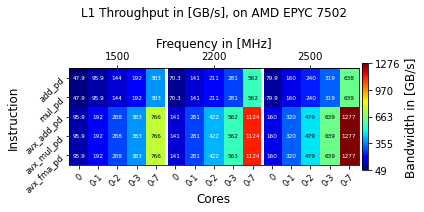

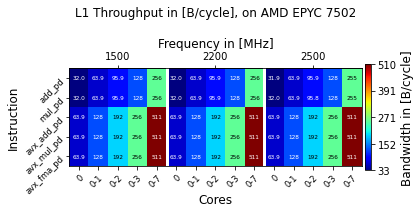

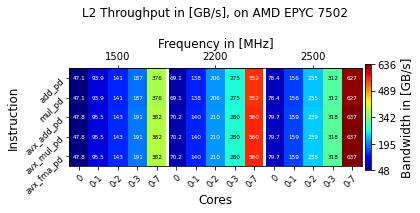

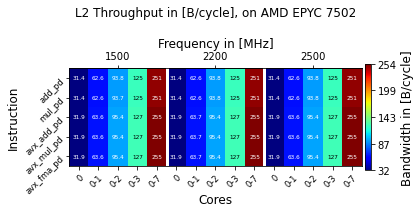

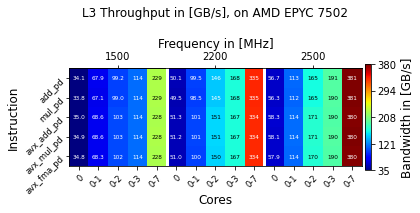

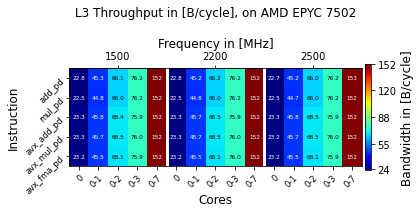

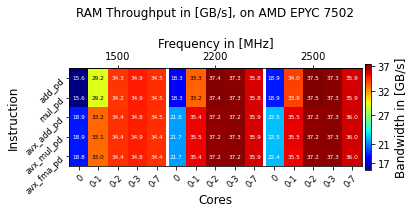

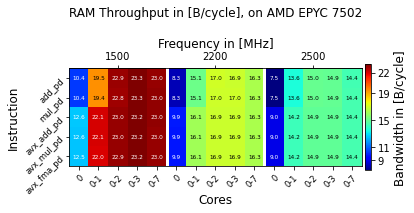

In [9]:
for size in log_progress(sizes):
    size_index = sizes.index(size)
    
    plotter(averages[size_index], size_index, frequencies, instructions, corelist, 
            'GB/s', 'GB_s', 'AMD EPYC 7502')
    plotter(averages_cycles[size_index], size_index, frequencies, instructions, corelist, 
            'B/cycle', 'B_cycle', 'AMD EPYC 7502')